In [1]:
# user defined functions
import odor_statistics_lib as osm

# dataframes
import pandas as pd
import h5py

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import signal
from scipy import stats

#plots
import string
import figurefirst
from figurefirst import FigureLayout,mpl_functions
import matplotlib.ticker as mtick

import pylab as plt
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns
sns.set()
sns.set_style("whitegrid")
pd.options.mode.chained_assignment = None

In [2]:
dir = '~/Documents/Myfiles/DataAnalysis/data/Sprints/HighRes/'

In [3]:
def get_statistics(df,index,fdf):
    osm.avg_distance(df,index,fdf)
    osm.mean_conc(df,index,fdf)
    osm.motion_statistics(df,index,fdf)
    osm.whiff_blank_duration(df,index,fdf)
    osm.trajectory_speed(df,index,fdf)
    osm.encounter_frequency(df,index,fdf,1,2)
#     osm.mean_avg(df,index,fdf)
    osm.mean_conc(df,index,fdf)

In [5]:
df = pd.read_hdf(dir+'Windy/WindyMASigned.h5')
# fdf = pd.read_hdf(dir+'Forest/ForestStatsTime_std.h5')
# df.distance_from_source=df.distance_from_source*df.xsign
# df.nearest_from_streakline=df.nearest_from_streakline*df.ysign

In [27]:
def project(a,b):
    return (np.dot(a, b) / np.dot(b, b)) * b

In [28]:
new_ground_speed=[]
for i in range(len(df)):
    wind= np.array([df.corrected_u[i],df.corrected_v[i]])
    gps=np.array([df.gps_linear_x[i],df.gps_linear_y[i]])
    new_ground_speed.append(project(gps,wind))
    
ngs=np.vstack(new_ground_speed)
df['ground_speed_x']=ngs[:,0]
df['ground_speed_y']=ngs[:,1]

In [29]:
df.to_hdf(dir+'NotWindy/NotWindyMASigned.h5', key='fdf', mode='w')

In [49]:
# f,ax=plt.subplots(1,1,figsize=(4,4))
# n, bins, patches = ax.hist((df.odor), 20, density=True, facecolor='b', alpha=0.75)
# ax.grid(False)
# mpl_functions.adjust_spines(ax,['left','bottom'],
#                            spine_locations={}, 
#                            smart_bounds=True,
#                            yticks=[0,.8,1.6],
#                            xticks=[0,5,10],
#                            linewidth=1)

# ax.set_xlabel('Odor Concentration, v')
# ax.set_ylabel('Frequency')
# ax.set_title("Odor Concentration\nHistogram, WS>3.5m/s")
# f.tight_layout()
# mpl_functions.set_fontsize(f, 18)
# f.savefig('../../Figure/HistWindy.jpeg', dpi=300, bbox_inches = "tight")
# # print(n,bins,patches)

In [6]:
np.seterr(divide = 'ignore') 
index = osm.get_index(df)
fdf = pd.DataFrame()
get_statistics(df,index,fdf)

In [56]:
np.seterr(divide = 'ignore') 
index = osm.get_index_forest(df)

In [7]:
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=200)
ma = df.odor.rolling(window=indexer, min_periods=1).mean()

In [8]:
moving_avg = []
i=0
while i<len(index):
    moving_avg.append(np.mean(ma[index[i]])) 
    i+=1
fdf['whiff_ma']=moving_avg

In [20]:
# i = 0
# std_whiff = []
# while i<len(index):
#     std_whiff.append(np.std(df.odor[index[i]])) 
#     i+=1
# fdf['std_whiff']=std_whiff

In [60]:
# dir ='~/Documents/MyFiles/DataAnalysis/data/Sprints/HighRes/'
fdf.to_hdf(dir+'Forest/ForestStatsTime_std.h5', key='fdf', mode='w')

### LOW PASS FILTER ANALYSIS

In [5]:
# np.seterr(divide = 'ignore') 
# index = osm.get_index(df)
# fdf = pd.DataFrame()
# osm.avg_distance(df,index,fdf)
# osm.mean_conc(df,index,fdf)

In [58]:
dt = df.time[1]-df.time[0]

In [7]:
l1 = list(np.arange(0.01,0.1,0.01))
l2 = [1,5,10,15,20,25,30,35,40]
kernel_size = l1+l2

m_ef=[]
for i in range(0,len(kernel_size)):
    m_ef.append(osm.encounter_frequency(df,index,fdf,1,kernel_size[i])) 
    

sl = []
r = []
for i in range(len(m_ef)):
#     print(i)
    slope, intercept, r_value, p_value, std_err = stats.linregress(fdf.log_avg_dist_from_source_signed,m_ef[i])
    sl.append(slope)
    r.append(r_value)
    
for i in range(len(m_ef)):
    fdf['mean_ef_'+str(i)]=m_ef[i]

In [8]:
# f,ax=plt.subplots(1,1,figsize=(8,6))
# ax.scatter(kernel_size,sl)
# ax.grid(False)
# ax.set_xlabel('Kernel Size, s')
# ax.set_ylabel('Slope')
# mpl_functions.adjust_spines(ax,['left', 'bottom'],spine_locations={},
#                             smart_bounds=True, xticks=[0.1,5,10,30,20,40], 
# #                             yticks=[-0,1,2.25],
#                             linewidth=1)


# f.suptitle(" Distance from Source vs Whiff Frequency\n Desert WS<3m/s")
# f.tight_layout(pad=1)
# figurefirst.mpl_functions.set_fontsize(f, 22)
# f.savefig('../../Figure/Slope_NWindy.jpeg', dpi=300, bbox_inches = "tight")

In [85]:
# for i in range(0,len(m_ef)):
#     f,ax1=plt.subplots(1,1,figsize=(8,6))

#     var1 = ax1.scatter(fdf.log_avg_dist_from_source, m_ef[i], c=fdf.mean_concentration, cmap='inferno_r', 
#                 edgecolors='none', alpha=0.2, vmin=4, vmax=10)
#     ax1.grid(False)

#     g1 =sns.regplot(x="log_avg_dist_from_source",y="mean_ef_"+str(i), data=fdf, 
#                 ax=ax1, line_kws={'color':'red','linewidth':5}, scatter=False, truncate=True)
#     g1.set(xlabel=None, ylabel=None)

#     ax1.set_ylabel('Whiff Frequency, hz')
#     ax1.set_xlabel('Distance from Source, m')

#     mpl_functions.adjust_spines(ax1,['left','bottom'],spine_locations={}, 
#                                 smart_bounds=True,
#                                 xticks=[-1,0.5,1.3],
#                                 yticks=[0,12],
#                                 linewidth=1)
#     ax1.set_xticklabels([r'-$10^{1}$',r'$10^{0.5}$', r'$10^{1.3}$'])

#     f.suptitle("Whiff Frequency vs DOS\n Kernel size ="+str(kernel_size[i])+" s")
#     f.tight_layout(pad=2)
#     figurefirst.mpl_functions.set_fontsize(f, 22)
#     f.savefig('../../Figure/WF_'+str(i)+'.jpeg', dpi=300, bbox_inches = "tight")

In [105]:
# fs=200
# nyq=fs*0.5
# cutoff_freq=(np.linspace(1,90,20)).astype(int)

# fpval=[]
# cfreq =[]
# rsquare=[]
# models=[]

# def load_data():
#     df = pd.read_hdf(dir+'Forest/ForestMA.h5')
#     return df

# for i in range(0,len(cutoff_freq)):
#     df = load_data()
#     sos = signal.butter(2, cutoff_freq[i], 'low',fs=200, output='sos')
#     filtered = signal.sosfilt(sos, df.odor)
#     df['filtered_odor']=filtered

#     index = osm.get_index_filtered(df)
#     fdf = pd.DataFrame()
#     np.seterr(divide = 'ignore') 
#     get_statistics(df,index,fdf)

#     whiff_frequency=smf.ols(formula='mean_ef ~ np.abs(fdf.avg_perpendicular_encounter) + np.abs(fdf.avg_parallel_encounter)', data=fdf).fit()
#     whiff_duration=smf.ols(formula='log_whiff~ np.abs(fdf.avg_perpendicular_encounter) + np.abs(fdf.avg_parallel_encounter)', data=fdf).fit()
#     moving_avg = smf.ols(formula='mean_ma ~ np.abs(fdf.avg_perpendicular_encounter) + np.abs(fdf.avg_parallel_encounter)', data=fdf).fit()

#     fdf['whiff_frequency_resid']=whiff_frequency.resid
#     fdf['whiff_duration_resid'] = whiff_duration.resid
#     fdf['moving_avg_resid'] = moving_avg.resid

#     distance=smf.ols(formula='log_avg_dist_from_source ~ whiff_duration_resid  + whiff_frequency_resid + moving_avg_resid', data=fdf).fit()
#     models.append(distance)
#     fpval.append(distance.f_pvalue)
#     rsquare.append(distance.rsquared)
#     cfreq.append(cutoff_freq[i])


In [7]:
# f,(ax1,ax2)=plt.subplots(2,1,figsize=(8,12))
# ax1.scatter(cutoff_freq, np.log10(fpval))
# ax2.scatter(cutoff_freq, rsquare)

# ax1.grid(False)
# ax2.grid(False)
# # ax1.set_yscale('log')
# mpl_functions.adjust_spines(ax1,['left'],spine_locations={},
#                             smart_bounds=True, yticks=[0,-7.5,-15],linewidth=1)

# mpl_functions.adjust_spines(ax2,['left', 'bottom'],spine_locations={},
#                             smart_bounds=True, xticks=[0,15,30,45,60,75,90],yticks=[0.002,0.008,0.014],linewidth=1)

# ax1.yaxis.set_label_coords(-0.20, 0.5)
# ax1.set_yticklabels([r'$10^{-15}$',r'$10^{-7.5}$', r'$10^{-0}$'])
# # ax1.set_xlabel('Cutoff Frequency, Hz')

# ax1.set_ylabel('log(F-Prob)')

# ax2.set_xlabel('Cutoff Frequency, Hz')
# ax2.set_ylabel('$R^{2}$')


# f.suptitle("$F-Prob$ & $R^{2}$ Forest\nLPF 0<Cutoff<90")
# f.tight_layout(pad=2)
# figurefirst.mpl_functions.set_fontsize(f, 22)
# f.savefig('../../Figure/LPF_Forest.jpeg', dpi=300, bbox_inches = "tight")

In [13]:
## calculation for moving average alignment
# newma=np.pad(df.ma_fraction,(200,0),mode='constant', constant_values=(0))
# newma=newma[:-200]

In [18]:
# df.to_hdf(dir+'NotWindy/NotWindyMASigned1.h5', key='df', mode='w')

### Odor Statistics Calculation Plots

In [7]:
# f,(ax)=plt.subplots(4,1,figsize=(8.5,11))
# ##plots
# ax[0].plot(df.time,df.odor)
# # ax[0].axhline(4.5, linestyle='dashed', color='r')
# ax[0].set_xlim(1535,1540)
# ax[1].plot(df.time,df.whiff_plot)
# ax[1].set_xlim(1535,1540)
# # ax[2].plot(df.time,df.efreq)
# # ax[2].set_xlim(1535,1540)
# ax[2].plot(df.time, df.encounter_frequency)
# ax[2].set_xlim(1535,1540)
# ax[3].plot(df.time,df.ma_fraction)
# ax[3].set_xlim(1535,1540)

# ## adjust spines and grids
# for i in range(4):
#     ax[i].grid(False)
    
# mpl_functions.adjust_spines(ax[0],['left'],spine_locations={},smart_bounds=True, yticks=[0,10],linewidth=1)

# for i in range(1,3):
#     mpl_functions.adjust_spines(ax[i],['left'],spine_locations={},smart_bounds=True, yticks=[0,1],linewidth=1)

# mpl_functions.adjust_spines(ax[2],['left'],spine_locations={},
#                             smart_bounds=True, yticks=[0,5],linewidth=1)

# mpl_functions.adjust_spines(ax[3],['left', 'bottom'],spine_locations={},
#                             smart_bounds=True,yticks=[0,1],linewidth=1)

# ## label
# ax[0].set_ylabel('Odor, V')
# ax[1].set_ylabel('Whiff\nDuration, V')
# # ax[2].set_ylabel('Encounter\nOnsets')
# ax[2].set_ylabel('Encounter\nFrequency,Hz')
# ax[3].set_ylabel('Moving\nAverage, V')
# ax[3].set_xlabel('Time, s')


# f.suptitle("Odor Statistics Calculation\nOdor Threshold > 4.5V")
# f.tight_layout(pad=2)
# figurefirst.mpl_functions.set_fontsize(f, 22)
# f.savefig('../../Figure/OdorStat.jpeg', dpi=300, bbox_inches = "tight")

### Odor Statistics Plots

In [71]:
avg_dist_along_streakline = []
i = 0
while i<len(index):
    avg_dist_along_streakline.append(np.mean(df.distance_from_source_a[index[i]]))
    i+=1
fdf['avg_dist_along_streakline']=avg_dist_along_streakline

In [6]:
# fdf=(fdf-fdf.mean())/fdf.std()
# nfdf=(fdf-fdf.min())/(fdf.max()-fdf.min())

In [7]:
# q = 'length_of_encounter >=0.1'
# fdf=fdf.query(q)

In [8]:
# q1='log_avg_dist_from_source_signed<0'
# fdf1=nfdf.query(q1)
# q2='log_avg_dist_from_source_signed>0'
# fdf2=nfdf.query(q2)

In [36]:
fdf = pd.read_hdf(dir+'NotWindy/NotWindyStats.h5')

In [31]:
query = 'mean_concentration>6'
fdft=fdf.query(query)

In [32]:
dataframe=fdft

In [33]:
a = dataframe.mean_concentration
b = dataframe.log_avg_dist_from_source_signed
# mask = ~np.isnan(fdf.log_avg_dist_from_source)
# mask = np.isfinite(fdf.log_avg_dist_from_source) & np.isfinite(a)
slope, intercept, r_value, p_value, std_err = stats.linregress(b,a)
# slope, intercept, r_value, p_value, std_err = stats.linregress(fdf.log_avg_dist_from_source[mask],a[mask])

if p_value<=0.05:
    print ('significant')
    print('r2_value:', "{:e}".format(r_value**2))
    print("p_value:", "{:e}".format(p_value))

else:
    print ('insignificant')
    print('r2_value:', "{:e}".format(r_value**2))
    print("p_value:", "{:e}".format(p_value))

significant
r2_value: 4.078685e-02
p_value: 3.182921e-21


In [37]:
fdf1.keys()

Index(['avg_dist_from_source', 'log_avg_dist_from_source', 'avg_xsign',
       'avg_dist_from_streakline', 'log_avg_dist_from_source_signed',
       'mean_concentration', 'avg_parallel_encounter',
       'avg_perpendicular_encounter', 'avg_parallel_intermittency',
       'avg_perpendicular_intermittency', 'length_of_encounter',
       'odor_intermittency', 'log_whiff', 'log_blank',
       'speed_at_intermittency', 'speed_at_encounter', 'mean_ef', 'mean_ma',
       'mean_time', 'type', 'std_whiff', 'whiff_ma'],
      dtype='object')

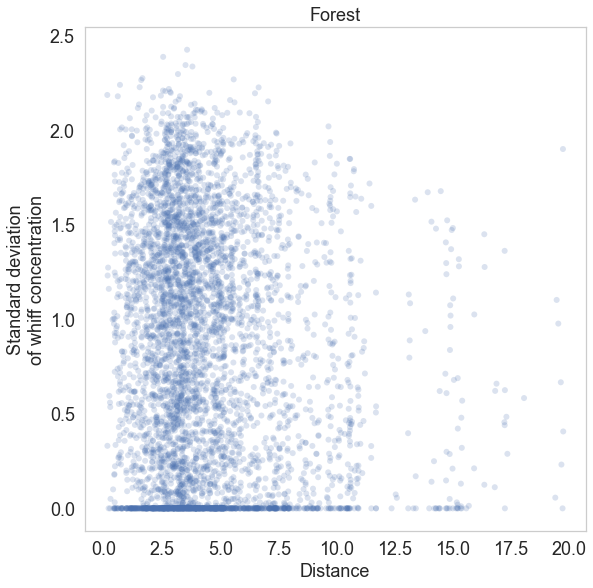

In [47]:
f, (ax1) = plt.subplots(1,1, figsize=(8,8))
                    
dataframe=fdf3
test_var=dataframe.std_whiff

var1 = ax1.scatter(dataframe.avg_dist_from_source, test_var, 
                   cmap='inferno', 
            edgecolors='none', alpha=0.2)
ax1.grid(False)
# ax1.set_ylim(4.5,)
# ax1.set_title('Desert WS<3.5m/s')
ax1.set_title('Forest')
# g1 = sns.regplot(x="avg_dist_from_source",y=test_var, data=dataframe, 
#             ax=ax1, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
# g1.set(xlabel=None, ylabel=None)

ax1.set_xlabel('Distance')
ax1.set_ylabel('Standard deviation\nof whiff concentration')


f.tight_layout(pad=1)
figurefirst.mpl_functions.set_fontsize(f, 18)
f.savefig('../../Figure/Plots/STD_Forest.jpeg', dpi=300, bbox_inches = "tight")


In [4]:
fdf1=pd.read_hdf(dir+'Windy/WindyStatsTime_std.h5')
fdf2=pd.read_hdf(dir+'NotWindy/NotWindyStatsTime_std.h5')
fdf3=pd.read_hdf(dir+'Forest/ForestStatsTime_std.h5')

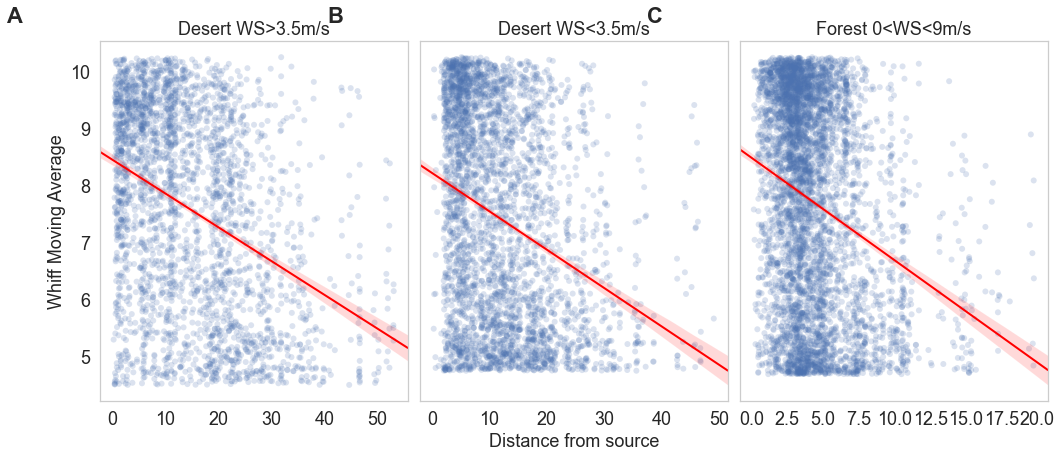

In [11]:
f, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(14,6))
                    


var1 = ax1.scatter(fdf1.avg_dist_from_source, fdf1.mean_concentration, 
                 cmap='inferno_r', 
            edgecolors='none', alpha=0.2, vmin=4, vmax=10)
ax1.grid(False)

g1 = sns.regplot(x="avg_dist_from_source",y="mean_concentration", data=fdf1, 
            ax=ax1, line_kws={'color':'red','linewidth':2}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

# mpl_functions.adjust_spines(ax1,['left','bottom'],
#                             spine_locations={}, 
#                             smart_bounds=True,
#                             xticks=[-1,0,1,1.8],
#                             yticks=[0,10],
#                             linewidth=1)
# ax1.set_xticklabels([r'$10^{-1}$',r'$10^{0}$', r'$10^{1}$',r'$10^{1.8}$'])

##########
var2 = ax2.scatter(fdf2.avg_dist_from_source, fdf2.mean_concentration, 
                   cmap='inferno_r', 
            edgecolors='none', alpha=0.2, vmin=4, vmax=10)
ax2.grid(False)
g2 = sns.regplot(x="avg_dist_from_source",y="mean_concentration", data=fdf2, 
            ax=ax2, line_kws={'color':'red','linewidth':2}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)
ax2.set_yticklabels("")
# mpl_functions.adjust_spines(ax2,['bottom'],
#                             spine_locations={}, 
#                             smart_bounds=True,
#                             xticks=[-1,0,1,1.8],
# #                             yticks=[0,4500],
#                             linewidth=1)
# # ax2.yaxis.set_label_coords(-0.23, 0.5)
# ax2.set_xticklabels([r'$10^{-1}$',r'$10^{0}$', r'$10^{1}$',r'$10^{1.8}$'])

##########


var3 = ax3.scatter(fdf3.avg_dist_from_source, fdf3.mean_concentration, 
                   cmap='inferno_r', 
            edgecolors='none', alpha=0.2, vmin=4, vmax=10)
ax3.grid(False)
g3 = sns.regplot(x="avg_dist_from_source",y="mean_concentration", data=fdf3, 
            ax=ax3, line_kws={'color':'red','linewidth':2}, scatter=False, truncate=False)
g3.set(xlabel=None, ylabel=None)
ax3.set_yticklabels("")

# mpl_functions.adjust_spines(ax3,['bottom'],
#                             spine_locations={}, 
#                             smart_bounds=True,
#                             xticks=[-1,0,1,1.8],
#                             yticks=[0,10],
#                             linewidth=1)
# ax3.set_xticklabels([r'$10^{-1}$',r'$10^{0}$', r'$10^{1}$',r'$10^{1.8}$'])

# divider = make_axes_locatable(ax3)
# cax3 = divider.append_axes('right', size='5%', pad=0.08)
# cbar3=f.colorbar(var3, cax=cax3, orientation = 'vertical', ticks=[0, 9])
# cbar3.ax.set_yticklabels(['0', '9'])
# cbar3.solids.set(alpha=1)
# cbar3.ax.set_ylabel('MA (V)', rotation=-90, labelpad=-5)

ax1.set_ylabel('Whiff Moving Average')
ax2.set_xlabel('Distance from source')
ax1.set_title('Desert WS>3.5m/s')
ax2.set_title('Desert WS<3.5m/s')
ax3.set_title('Forest 0<WS<9m/s')

ax=[ax1,ax2,ax3]

f.tight_layout(pad=1)
figurefirst.mpl_functions.set_fontsize(f, 18)
for i in range(len(ax)):
    ax[i].text(-0.3, 1.05, string.ascii_uppercase[i], transform=ax[i].transAxes, weight='bold', fontsize=22)

# f.savefig('../../Figure/WCAll.jpeg', dpi=300, bbox_inches = "tight")

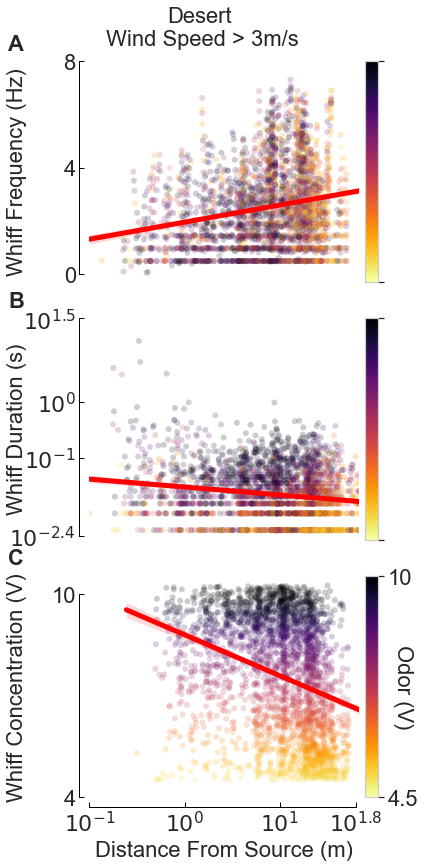

In [35]:
f,(ax1,ax2,ax3)=plt.subplots(3,1, figsize=(6,12))

color_whiff = 'red'
color_ef ='red'
color_ma = 'red'


var1 = ax1.scatter(dataframe.log_avg_dist_from_source_signed, dataframe.mean_ef, 
                   c=dataframe.mean_concentration, cmap='inferno_r', 
            edgecolors='none', alpha=0.2, vmin=4, vmax=10)
ax1.grid(False)
g1 = sns.regplot(x="log_avg_dist_from_source_signed",y="mean_ef", data=dataframe, 
            ax=ax1, line_kws={'color':color_ef,'linewidth':5}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)
# ax1.set_xlabel('Distance From Source (m)')
ax1.set_ylabel('Whiff Frequency (Hz)')

mpl_functions.adjust_spines(ax1,['left'],
                            spine_locations={}, 
                            smart_bounds=True,     
                            yticks=[0,4,8],
                            linewidth=1)
ax1.yaxis.set_label_coords(-0.23, 0.5)

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var1, cax=cax1, orientation = 'vertical', ticks=[4, 10])
cbar1.solids.set(alpha=1)
cbar1.ax.set_yticklabels([])


########## subplot 2 #############
var2 = ax2.scatter(dataframe.log_avg_dist_from_source_signed, dataframe.log_whiff, 
                   c=dataframe.mean_concentration, cmap='inferno_r', 
            edgecolors='none', alpha=0.2, vmin=4, vmax=10)
ax2.grid(False)
g2 =sns.regplot(x="log_avg_dist_from_source_signed",y="log_whiff", data=dataframe, 
            ax=ax2, line_kws={'color':color_whiff,'linewidth':5}, scatter=False, truncate=True)
g2.set(xlabel=None, ylabel=None)

ax2.set_ylabel('Whiff Duration (s)')
mpl_functions.adjust_spines(ax2,['left'],
                            spine_locations={}, 
                            smart_bounds=True,
                           
                            yticks=[-2.4,-1,0,1.5],
                            linewidth=1)
ax2.yaxis.set_label_coords(-0.23, 0.5)
ax2.set_yticklabels([r'$10^{-2.4}$',r'$10^{-1}$', r'$10^0$', r'$10^{1.5}$'])

divider = make_axes_locatable(ax2)
cax2 = divider.append_axes('right', size='5%', pad=0.08)
cbar2=f.colorbar(var2, cax=cax2, orientation = 'vertical', ticks=[4, 10])
cbar2.solids.set(alpha=1)
cbar2.ax.set_yticklabels([])

########## subplot 1 #############

var3 = ax3.scatter(dataframe.log_avg_dist_from_source_signed, dataframe.mean_concentration, 
                   c=dataframe.mean_concentration, cmap='inferno_r', 
                   edgecolors='none', alpha=0.2, vmin=4, vmax=10)
ax3.grid(False)

g3=sns.regplot(x="log_avg_dist_from_source_signed",y="mean_concentration", data=dataframe, 
            ax=ax3, line_kws={'color':color_ma,'linewidth':5}, scatter=False, truncate=False)
g3.set(xlabel=None, ylabel=None)
ax3.set_xlabel('Distance From Source (m)')
ax3.set_ylabel('Whiff Concentration (V)')
mpl_functions.adjust_spines(ax3,['left','bottom'],
                            spine_locations={}, 
                            smart_bounds=True,
                            xticks=[-1,0,1,1.8],
                            yticks=[4,10],
                            linewidth=1)
ax3.yaxis.set_label_coords(-0.23, 0.5)
ax3.set_xticklabels([r'$10^{-1}$',r'$10^{0}$', r'$10^{1}$',r'$10^{1.8}$'])


divider = make_axes_locatable(ax3)
cax3 = divider.append_axes('right', size='5%', pad=0.08)
cbar3=f.colorbar(var3, cax=cax3, orientation = 'vertical', ticks=[4, 10])
cbar3.ax.set_yticklabels(['4.5', '10'])
cbar3.solids.set(alpha=1)
cbar3.ax.set_ylabel('Odor (V)', rotation=-90, labelpad=-5)


########## subplot 3 #############
# ax1.set_title('Forest 0<WS<9m/s')
f.suptitle('Desert\n Wind Speed > 3m/s')
# f.suptitle("Forest\n0>WS>9m/s\n +ve x-axis")
ax=[ax1,ax2,ax3]
for i in range(len(ax)):
     ax[i].text(-0.3, 1.05, string.ascii_uppercase[i], transform=ax[i].transAxes, weight='bold')


f.tight_layout(pad=1)
figurefirst.mpl_functions.set_fontsize(f, 22)

f.savefig('../../Figure/Desert_LWS.jpeg', dpi=300, bbox_inches = "tight")

## Box Cox Transform

In [6]:
fitted_ef, fitted_lambda1 = stats.boxcox(fdf.mean_ef)
fdf.mean_ma=fdf.mean_ma+0.1
fitted_ma, fitted_lambda2 = stats.boxcox(fdf.mean_ma)
fitted_wd, fitted_lambda3 = stats.boxcox(fdf.length_of_encounter)

trans_df=pd.DataFrame()
trans_df['mean_ef']=fitted_ef
trans_df['mean_ma']=fitted_ma
trans_df['log_whiff']=fitted_wd
trans_df['avg_parallel_encounter'] =fdf.avg_parallel_encounter
trans_df['avg_perpendicular_encounter'] =fdf.avg_perpendicular_encounter
trans_df['log_avg_dist_from_source_signed']=fdf.avg_dist_from_source*fdf.avg_xsign
trans_df['mean_concentration']=fdf.mean_concentration

In [63]:
dat=fdf3

In [64]:
whiff_frequency=smf.ols(formula='mean_ef ~ (avg_perpendicular_encounter) + (avg_parallel_encounter)', data=dat).fit()
whiff_duration=smf.ols(formula='log_whiff~ (avg_perpendicular_encounter) + (avg_parallel_encounter)', data=dat).fit()
moving_avg = smf.ols(formula='mean_ma ~ (avg_perpendicular_encounter) + (avg_parallel_encounter)', data=dat).fit()
mc = smf.ols(formula='mean_concentration ~ (avg_perpendicular_encounter) + (avg_parallel_encounter)', data=dat).fit()

In [65]:
dat['whiff_frequency_resid']=whiff_frequency.resid
dat['whiff_duration_resid'] = whiff_duration.resid
dat['moving_avg_resid'] = moving_avg.resid
dat['mc_resid'] = mc.resid

In [66]:
# q1='log_avg_dist_from_source<0'
# fdf1=fdf.query(q1)
# q2='log_avg_dist_from_source>=0'
# fdf2=fdf.query(q2)

In [67]:
distance=smf.ols(formula='log_avg_dist_from_source_signed~ mc_resid + whiff_duration_resid  + whiff_frequency_resid + moving_avg_resid', data=dat).fit()
print(distance.summary())

                                   OLS Regression Results                                  
Dep. Variable:     log_avg_dist_from_source_signed   R-squared:                       0.072
Model:                                         OLS   Adj. R-squared:                  0.071
Method:                              Least Squares   F-statistic:                     96.85
Date:                             Thu, 23 Jun 2022   Prob (F-statistic):           1.76e-79
Time:                                     12:08:47   Log-Likelihood:                -454.36
No. Observations:                             4986   AIC:                             918.7
Df Residuals:                                 4981   BIC:                             951.3
Df Model:                                        4                                         
Covariance Type:                         nonrobust                                         
                            coef    std err          t      P>|t|      [0.025   

In [68]:
print("WF - p_value: " "{:e}".format(distance.pvalues.whiff_frequency_resid))
print("MC - p_value: " "{:e}".format(distance.pvalues.mc_resid))
print("WD - p_value: " "{:e}".format(distance.pvalues.whiff_duration_resid))
print("WMA - p_value: " "{:e}".format(distance.pvalues.moving_avg_resid))


WF - p_value: 9.038335e-04
MC - p_value: 2.811823e-73
WD - p_value: 6.665239e-18
WMA - p_value: 6.018062e-02


Box Cox improves the heteroskedacity in Lower wind speed dataset, BP Test p-value goes from $3.001e^{-03}$ to $3.979e^{-01}$ , however $R^2$ and model significance $f-pvalue$ lowers. Below shows the distribution after applying log transform and box-cox transform 

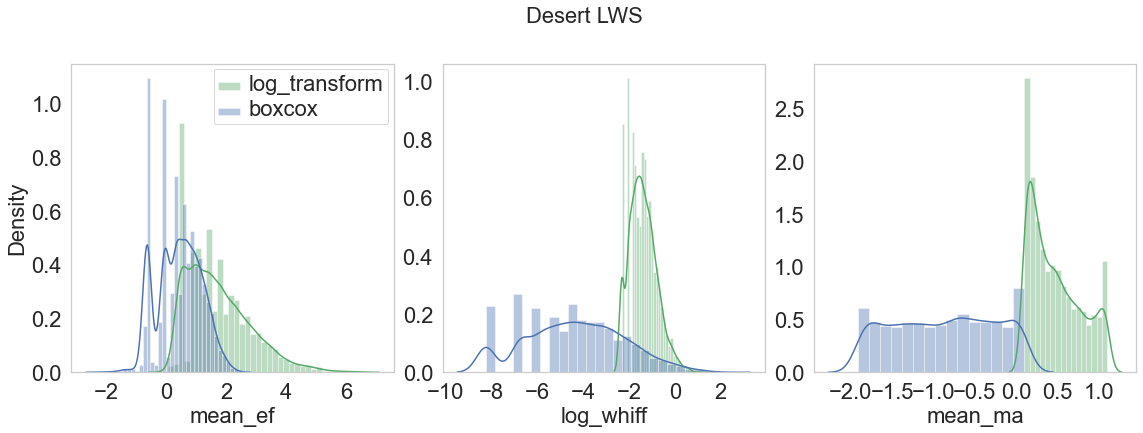

In [48]:
f,ax=plt.subplots(1,3,figsize=(16,6))
sns.distplot(fdf.mean_ef, color='g', ax=ax[0], label='log_transform')
sns.distplot(trans_df.mean_ef, ax=ax[0], label='boxcox')

sns.distplot(fdf.log_whiff, color='g', ax=ax[1])
sns.distplot(trans_df.log_whiff, ax=ax[1])

sns.distplot(fdf.mean_ma, color='g', ax=ax[2])
sns.distplot(trans_df.mean_ma, ax=ax[2])

for i in range(3):
    ax[i].grid(False)

ax[0].legend()        

ax[1].set_ylabel('')
ax[2].set_ylabel('')
f.suptitle('Desert LWS', fontsize=18)
f.tight_layout(pad=2)
figurefirst.mpl_functions.set_fontsize(f, 22)

### Normality Analysis

In [21]:
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
name = ["Jarque-Bera", "Chi^2 two-tail prob.", "Skew", "Kurtosis"]
test = sms.jarque_bera(distance.resid)
lzip(name, test)

[('Jarque-Bera', 118.97247302095705),
 ('Chi^2 two-tail prob.', 1.4637123403001896e-26),
 ('Skew', -0.4037700952510633),
 ('Kurtosis', 3.407177225403563)]

### Breusch Pagan Test
more about BP Test: https://stats.stackexchange.com/questions/155495/what-is-criterion-for-breusch-pagan-test

In [22]:
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(distance.resid, distance.model.exog)
lzip(name, test)

[('Lagrange multiplier statistic', 13.930256198094515),
 ('p-value', 0.003001639562512519),
 ('f-value', 4.656679996074543),
 ('f p-value', 0.0029821982725497273)]

###### Diagnostic plots

Let's check that the assumptions of the model have not been violated. Specifically, we look to see:

* the residuals are well distributed (standardized residuals vs predicted)
* the residuals follow a normal distribution (shapiro-wilks test) since we are using a linear model, not generalized
* check the heteroscedasticity (Q-Q plot)
* the variance is not a function of the output (observed vs predicted)
As with the $R^2$ situation, we will look at predictions and residuals that include the fixed and random effects, or only the fixed, since we are using a mixed effects linear model.

Some useful stuff:

https://www.qualtrics.com/support/stats-iq/analyses/regression-guides/interpreting-residual-plots-improve-regression/


### Actual vs Predicted

The scatter data should fall evenly around the red line, without any major patterns.


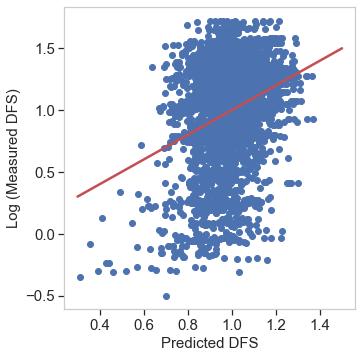

In [211]:
f,ax=plt.subplots(1,1,figsize=(5,5))
b, a = np.polyfit(distance.fittedvalues,fdf.log_avg_dist_from_source_signed, deg=1)
xseq = np.linspace(.3, 1.5, num=100)

ax.set_xlabel('Predicted DFS')
ax.set_ylabel('Log (Measured DFS)')
# Plot regression line
ax.plot(xseq, a + b * xseq, color="r", lw=2.5);
ax.scatter(distance.fittedvalues, fdf.log_avg_dist_from_source_signed)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.grid(False)

for tick in ax.xaxis.get_major_ticks():
    tick.tick1line.set_visible(True)

for tick in ax.yaxis.get_major_ticks():
    tick.tick1line.set_visible(True)
    
f.tight_layout(pad=1)
figurefirst.mpl_functions.set_fontsize(f, 15)
f.savefig('../../Figure/ActPred.jpeg', dpi=300, bbox_inches = "tight")


### Standardized residuals

Standardized residuals = (observed - expected) / std_dev(expected)

The scatter should be evenly distributed around the red line, without any obvious patterns, like growing or shrinking residuals as a function of predicted value.



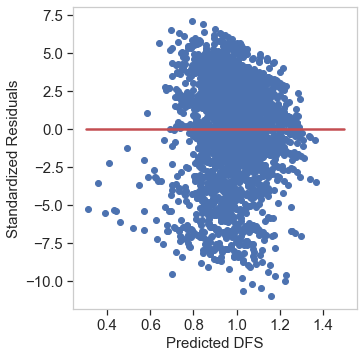

In [212]:
f,ax=plt.subplots(1,1,figsize=(5,5))
standardized_residuals = (fdf.log_avg_dist_from_source_signed - distance.fittedvalues) / np.std(distance.fittedvalues)
b, a = np.polyfit(distance.fittedvalues, standardized_residuals, deg=1)
xseq = np.linspace(.3, 1.5, num=100)

ax.set_xlabel('Predicted DFS')
ax.set_ylabel('Standardized Residuals')
# Plot regression line
ax.plot(xseq, a + b * xseq, color="r", lw=2.5);
ax.scatter(distance.fittedvalues, standardized_residuals)
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.grid(False)

for tick in ax.xaxis.get_major_ticks():
    tick.tick1line.set_visible(True)

for tick in ax.yaxis.get_major_ticks():
    tick.tick1line.set_visible(True)
    
f.tight_layout(pad=1)
figurefirst.mpl_functions.set_fontsize(f, 15)
f.savefig('../../Figure/StdResid.jpeg', dpi=300, bbox_inches = "tight")

### Residual Analysis
### Q-Q plot

The scatter should follow the red line, especially in the middle. Looks pretty good here. The plots shows there is a central peak in distribution



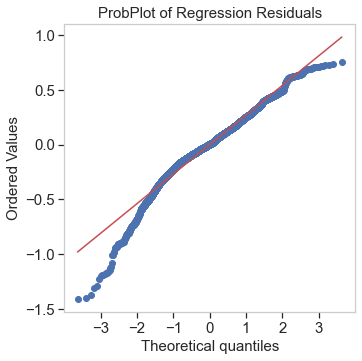

In [198]:
f,ax=plt.subplots(1,1,figsize=(5,5))
ax.grid(False)
stats.probplot(distance.resid,plot=ax)
f.tight_layout(pad=1)
# f.suptitle('Q-Q Plot')
ax.set_title('ProbPlot of Regression Residuals')
for tick in ax.xaxis.get_major_ticks():
    tick.tick1line.set_visible(True)

for tick in ax.yaxis.get_major_ticks():
    tick.tick1line.set_visible(True)

figurefirst.mpl_functions.set_fontsize(f, 15)
f.savefig('../../Figure/qq.jpeg', dpi=300, bbox_inches = "tight")


### Normality of residuals

The residuals should be normally distributed in this case, because we are using a linear model that assumes that the residuals are going to be normally distributed.

Not ideal here, there seem to be more small residuals than a normal distribution would predict.

** for hist plots
density=True represents the frequency distribution

density=False represents the probability density distribution


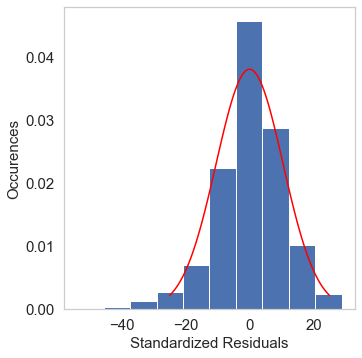

In [200]:
f,ax=plt.subplots(1,1,figsize=(5,5))
ax.hist(standardized_residuals, density=True, stacked=True)

rv = stats.norm(0, np.std(standardized_residuals))
x = np.linspace(-25,25,100)
pdf = rv.pdf(x)
ax.plot(x, pdf, color='red')
ax.set_xlabel('Standardized Residuals')
ax.set_ylabel('Occurences')
ax.grid(False)
# ax.set_title('Conditional (fixed and random effects)')
f.tight_layout(pad=1)
figurefirst.mpl_functions.set_fontsize(f, 15)
f.savefig('../../Figure/OccuResid.jpeg', dpi=300, bbox_inches = "tight")